# Re-analysis of the Cao et al single-cell dataset for enrichment of ascr#10 signatures.



In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import scanpy as sc

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

sc.settings.verbosity = 3
gene_names = sc.queries.biomart_annotations('celegans', ['ensembl_gene_id', 'external_gene_name',
                                                         'description', 'chromosome_name', 'gene_biotype'])

Load the data:

In [3]:
data = sc.read_loom('../data/All_Cells.loom')
data = data[~data.obs.Tissue.isin(['Unknown', 'Unannotated', 'Muscle_mesoderm'])]
data.var = data.var.join(gene_names.set_index('ensembl_gene_id'))

Next, we define the QC workflow. Moreover, the Cao dataset is huge and enormously unbalanced (some tissues are much more over-represented over others). Therefore, I also wrote a subsampling function that will make the dataset smaller and also equalize the tissue representation across the dataset, to the extent that that is possible.

In [70]:
def qc(single_cell):
    """
    Performs a fairly standard QC workflow.
    Cells with <150 genes are filtered out.
    Genes expressed in <50 cells are removed.
    QC metrics for mitochondrial content, riboprotein content and NADH-enzymes are calculated.
    Cells counts are normalized to counts per thousand (CPT). Because all cells data ~300 counts / cell,
    CPTs are NOT log-transformed
    A subset scanpy object is returned.
    """
    data = single_cell.copy()
    sc.pp.filter_cells(data, min_genes=150)
    sc.pp.filter_genes(data, min_cells=50)
    data.var['mt'] = data.var.chromosome_name.fillna('').str.startswith('Mt') # annotate the group of mitochondrial genes as 'mt'
    data.var['riboprots'] = data.var.external_gene_name.fillna('').str.contains('^rp[sl]')
    data.var['nadh'] = data.var.description.fillna('').str.lower().str.contains('nadh')
    sc.pp.calculate_qc_metrics(data, qc_vars=['mt', 'riboprots', 'nadh'], percent_top=None, log1p=False, inplace=True)
    sc.pp.normalize_total(data, target_sum=10 ** 3)
    return data

def subsample(single_cell):
    """
    subsample all the cell types so that they are equally representeded.
    """
    index = []
    for tissue, df in single_cell.obs.groupby('Tissue'):
        print(tissue)
        if tissue in ['Rectal_cells', 'Excretory']:
            print('here')
            continue
        elif tissue is not 'Neuron':
            index += df.sample(np.min([df.shape[0], 2000])).index.tolist()
        else:
            index += df.sample(np.min([df.shape[0], 2000])).index.tolist()

    temp = single_cell[index].copy()
    sc.pp.highly_variable_genes(temp)
    sc.pp.scale(temp)
    sc.pp.pca(temp)
    return temp


In the next cell, I process the data using my `qc` function, and then I further subset cells to remove cells with <250 reads, that have too few or way too much mitochondrial, riboprotein or NADH-enzyme content. Neuronal cells are weird, so I remove neuronal cells with more than 800 counts per cell. Please note the Cao et al dataset is unusual in that the average cell has VERY few counts, even for single-cell data. 

filtered out 19453 cells that have less than 150 genes expressed
filtered out 7018 genes that are detected in less than 50 cells
normalizing counts per cell
    finished (0:00:00)
AnnData object with n_obs × n_vars = 69231 × 13194
    obs: 'Barcode', 'Cell.type', 'Detection', 'Experiment', 'PValue', 'SCT_snn_res.1.5', 'Sample', 'Size_Factor', 'Tissue', 'UMAP.clusters', 'UMAP_1', 'UMAP_2', 'birthtime', 'log10_total_counts', 'log10_total_features_by_counts', 'modality', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'neurotransmitter', 'num_genes_expressed', 'orig.ident', 'partition', 'pct_counts_Mito', 'seurat_clusters', 'total_counts', 'total_features_by_counts', 'n_genes', 'n_genes_by_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_riboprots', 'pct_counts_riboprots', 'total_counts_nadh', 'pct_counts_nadh'
    var: 'external_gene_name', 'description', 'chromosome_name', 'gene_biotype', 'n_cells', 'mt', 'riboprots', 'nadh', 'n_cells_by_counts', 'mean_counts', 'pc

/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Cell.type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Detection' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Experiment' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Tissue' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'UMAP.clusters' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'birthtime' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'modality' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'neurotransm

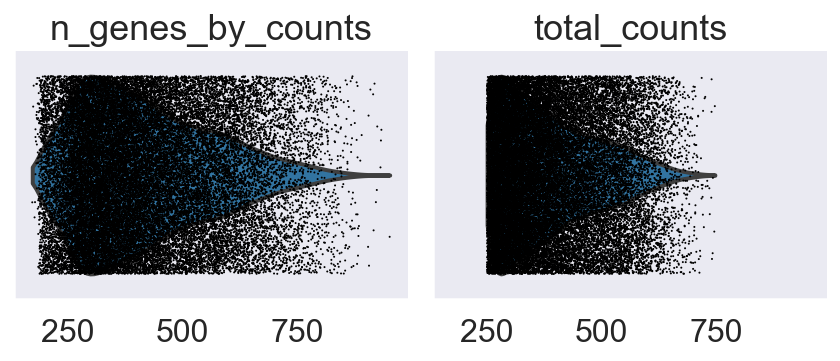

/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWar

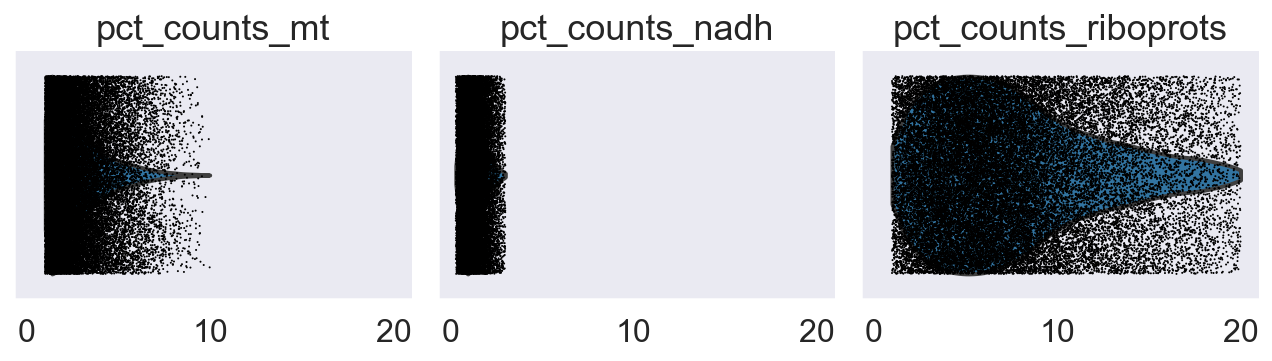

In [54]:
new = qc(data)

# subset data to keep only high quality stuff:
new = new[(new.obs.total_counts > 250) &
          (new.obs.pct_counts_mt.between(1, 10)) &
          (new.obs.pct_counts_riboprots.between(1, 20)) &
          (new.obs.pct_counts_nadh.between(.3, 3)) &
              ( ((new.obs.Tissue == 'Neuron') & (new.obs.total_counts < 800)) |
                (new.obs.Tissue != 'Neuron')
              )
         ]

sc.pl.violin(new, ['n_genes_by_counts', 'total_counts',],
             jitter=0.4, multi_panel=True)
sc.pl.violin(new, ['pct_counts_mt', 'pct_counts_nadh', 'pct_counts_riboprots'],
             jitter=0.4, multi_panel=True)

## QC Plots for single-cell rna-seq.

Let's make sure the cells look broadly OK:

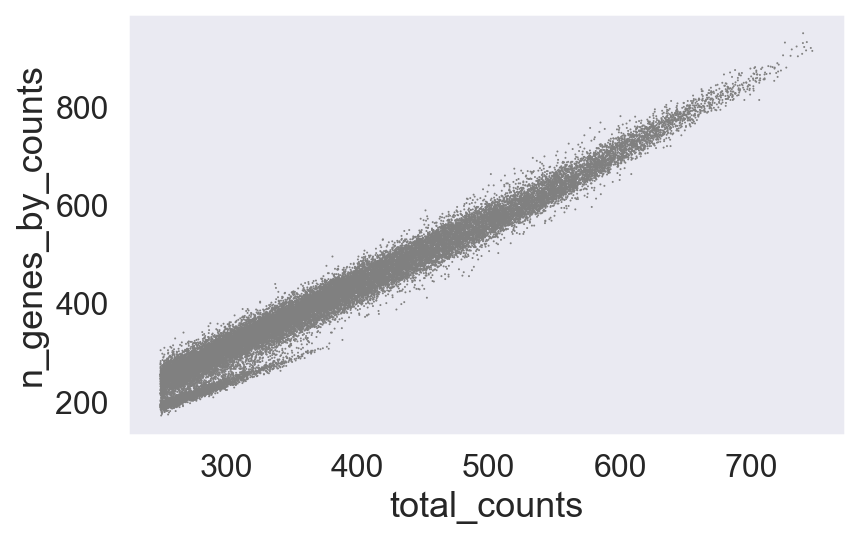

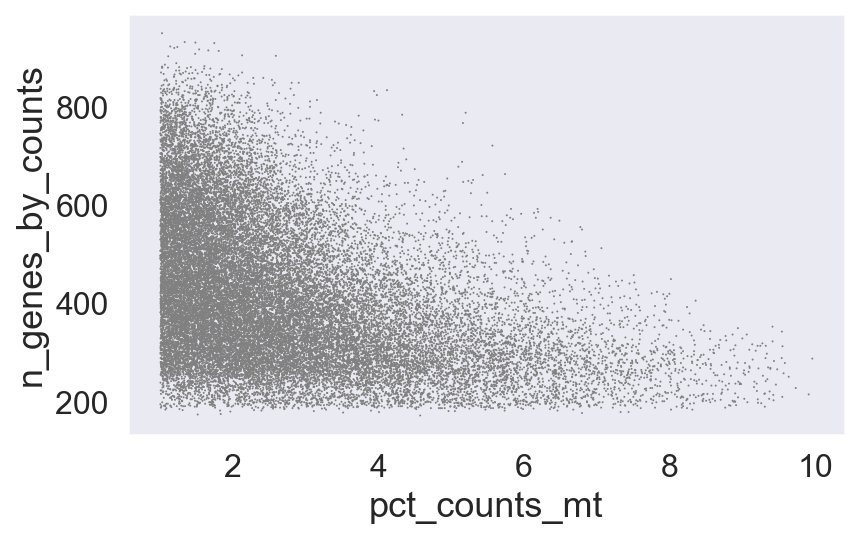

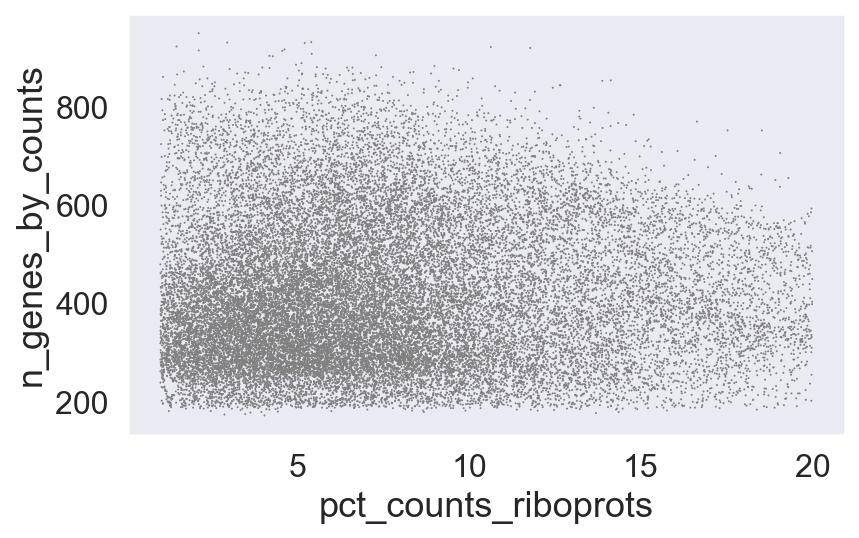

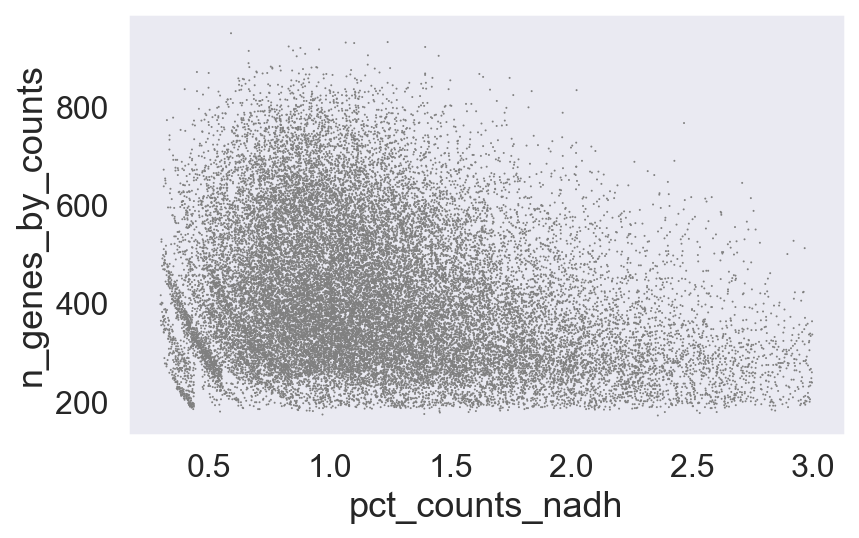

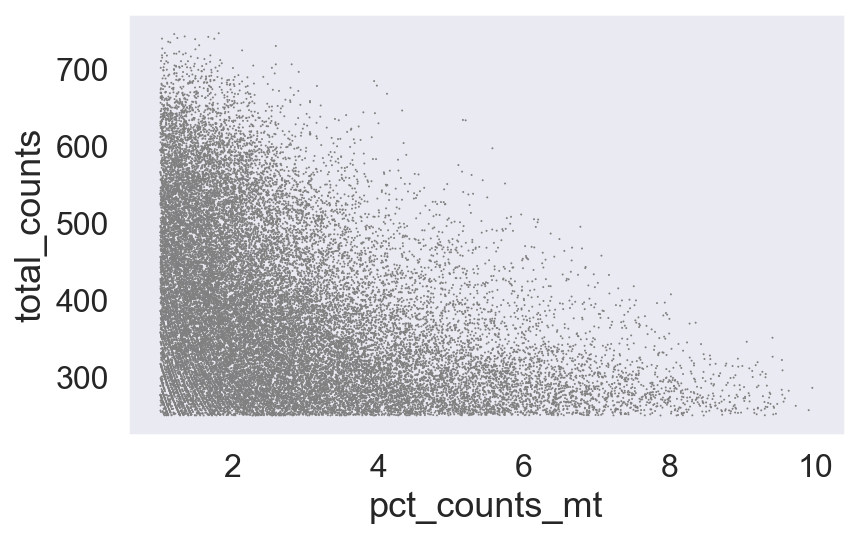

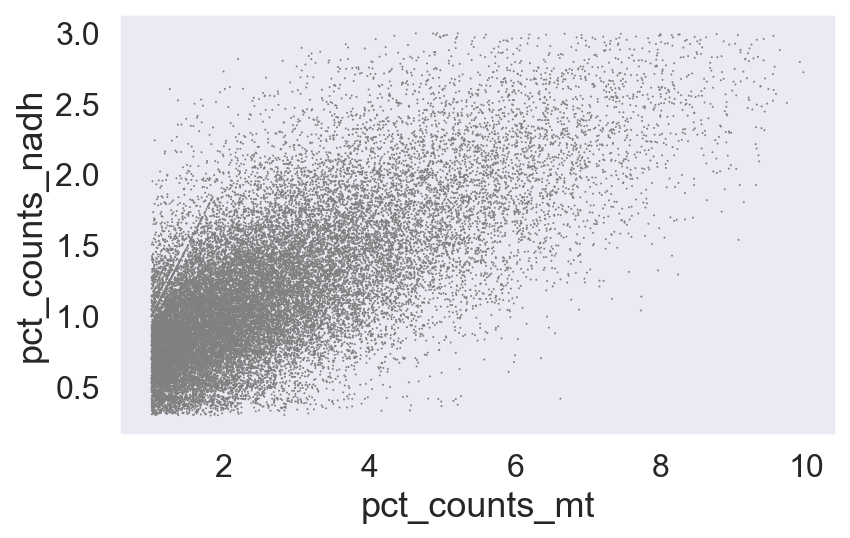

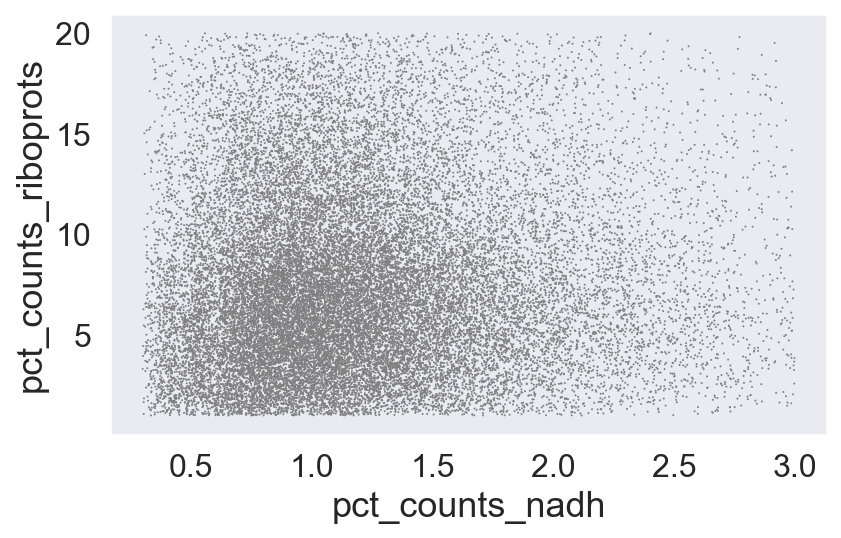

In [55]:
sc.pl.scatter(new, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(new, x='pct_counts_mt', y='n_genes_by_counts')
sc.pl.scatter(new, x='pct_counts_riboprots', y='n_genes_by_counts')
sc.pl.scatter(new, x='pct_counts_nadh', y='n_genes_by_counts')
sc.pl.scatter(new, x='pct_counts_mt', y='total_counts')
sc.pl.scatter(new, x='pct_counts_mt', y='pct_counts_nadh')
sc.pl.scatter(new, x='pct_counts_nadh', y='pct_counts_riboprots')

## Subsample and embed single cell data

The workflow below is fairly self explanatory. PCA, clustering, UMAP to make sure nothing is glaringly wrong. 

Excretory
here
Glia
Hypodermis
Intestine
Neuron
Pharynx
Rectal_cells
here
Reproductive
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing PCA
    on highly variable genes
    with n_comps=15
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


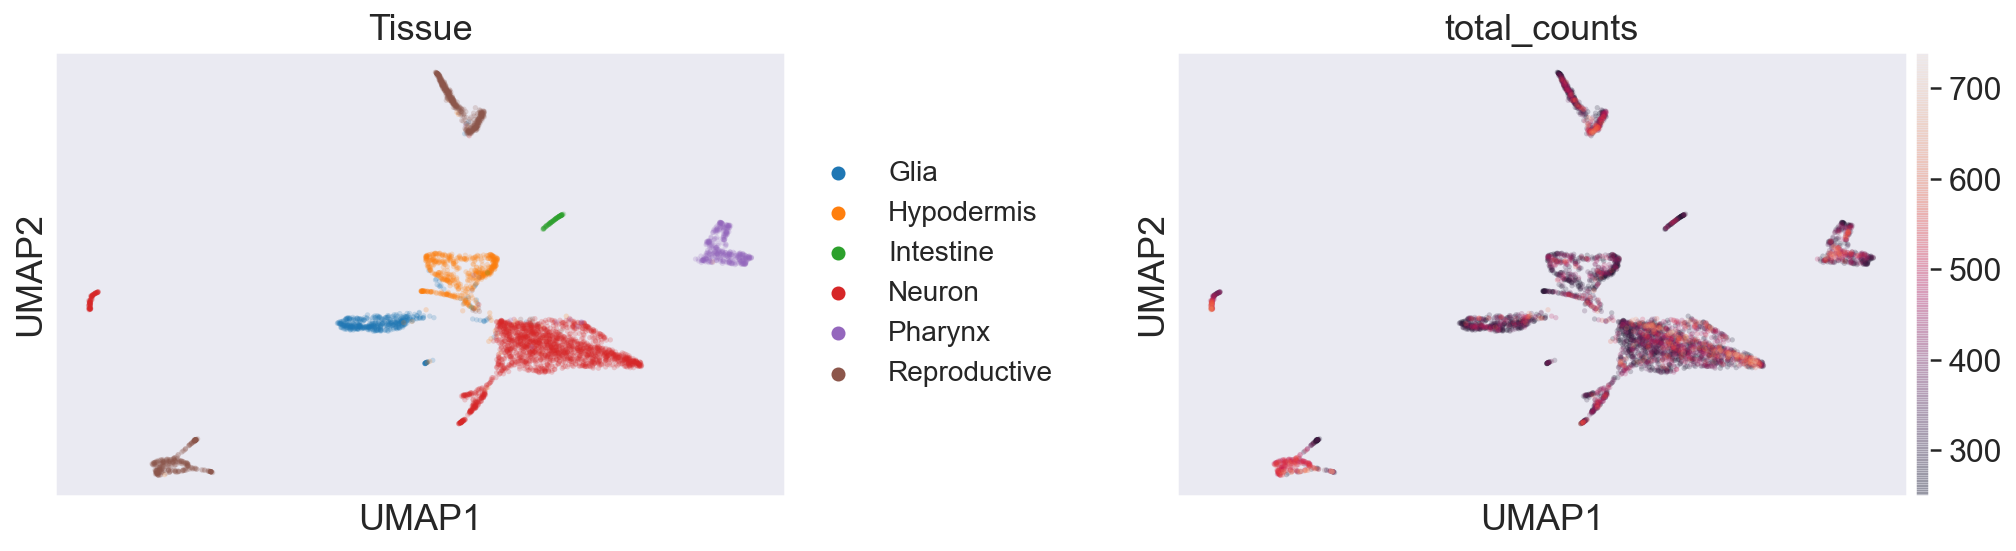

In [56]:
new = subsample(new)
sc.pp.pca(new, n_comps=15)
sc.pp.neighbors(new, n_neighbors=100)
sc.tl.umap(new, min_dist=.2)
sc.pl.umap(new, color=['Tissue', 'total_counts'], wspace=0.4, alpha=0.2)

## Reformatting the labels and adjusting UMAP.

I want the sperm and oocyte/oocyte-precursor cells to be labeled independently. In the above, they are all pooled as 'reproductive'. I wrote a short function to split them up.

Next, we use PAGA to help guide the UMAP into a slightly better conformation, and we plot the new UMAP, colored by the fixed labels.

In [57]:
def map_germline(x):
    """
    A way to rename the tissue samples such that the `Reproductive` term is split into Germline and Sperm.
    """
    if x['Cell.type'] == 'Sperm':
        return 'Sperm'
    elif x['Cell.type'] == 'Germline':
        return 'Germline'
    elif x.Tissue == 'Reproductive':
        return 'Somatic Reproductive'
    else:
        return x.Tissue

new.obs['NewTissue'] = new.obs.apply(map_germline, axis=1)

... storing 'NewTissue' as categorical


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


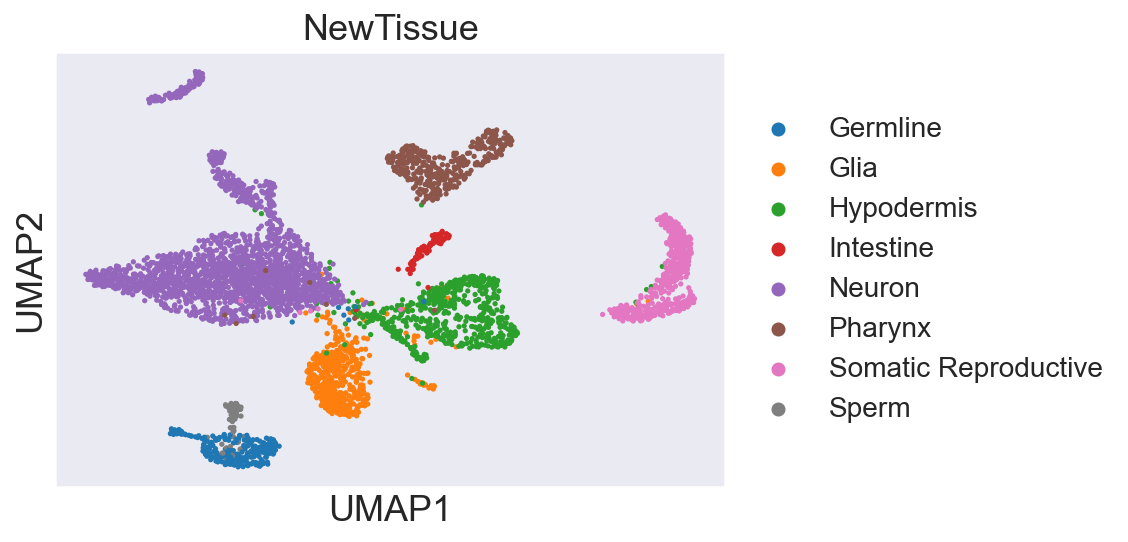

In [58]:
sc.tl.paga(new, groups='NewTissue')
sc.pl.paga(new)
sc.tl.umap(new, init_pos='paga', min_dist=1, spread=2)

sc.pl.umap(new, color=['NewTissue'])

## Positive and negative ascr#10 signatures.

Next, we load our gene data and we set stringent conditions to find those genes that are most significantly up- or down-regulated in response to ascr#10 at either 50 or 58hrs. To be sure that whatever results we are looking at mean *something*, we also generated a random signature from random genes in our dataset.

In [59]:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)
# keep DE genes only:
sel = (res['Sign-WT'] == 'Same') &\
      (res['padj-50'] < 0.01) & (res['padj-58'] < 0.01)

In [60]:
pos_signature = res[sel & (res['log2FoldChange-58'] > 0)].index.values
neg_signature = res[sel & (res['log2FoldChange-58'] < 0)].index.values
random = res.sample(np.max([len(pos_signature), len(neg_signature)]), replace=False).index.values
print(len(pos_signature), len(neg_signature))

200 148


In [61]:
print('positive genes found: ', len([p for p in pos_signature if p in new.var_names]))
print('negative genes found: ', len([p for p in neg_signature if p in new.var_names]))
print('random genes found: ', len([p for p in random if p in new.var_names]))

positive genes found:  198
negative genes found:  109
random genes found:  159


I use the `score_genes` function in scanpy to generate a composite score for each of the positive, negative and random signatures we generated. Higher composite scores in a given tissue mean that the set of genes that participate in that score are expressed at higher levels relative to the bulk average expression. Thus, higher scores, in a sense, indicate some sort of tissue-specificity for our purposes.

In [62]:
sc.tl.score_genes(new, pos_signature, score_name='PosAscrScore')
sc.tl.score_genes(new, neg_signature, score_name='NegAscrScore')
sc.tl.score_genes(new, random, score_name='RandomScore')

computing score 'PosAscrScore'
    finished: added
    'PosAscrScore', score of gene set (adata.obs).
    1179 total control genes are used. (0:00:00)
computing score 'NegAscrScore'
    finished: added
    'NegAscrScore', score of gene set (adata.obs).
    1190 total control genes are used. (0:00:00)
computing score 'RandomScore'
    finished: added
    'RandomScore', score of gene set (adata.obs).
    1183 total control genes are used. (0:00:00)


Tissue
Glia           -0.361782
Neuron         -0.283467
Hypodermis     -0.168839
Intestine       0.127532
Pharynx         0.150896
Reproductive    1.000000
Name: PosAscrScore, dtype: float64

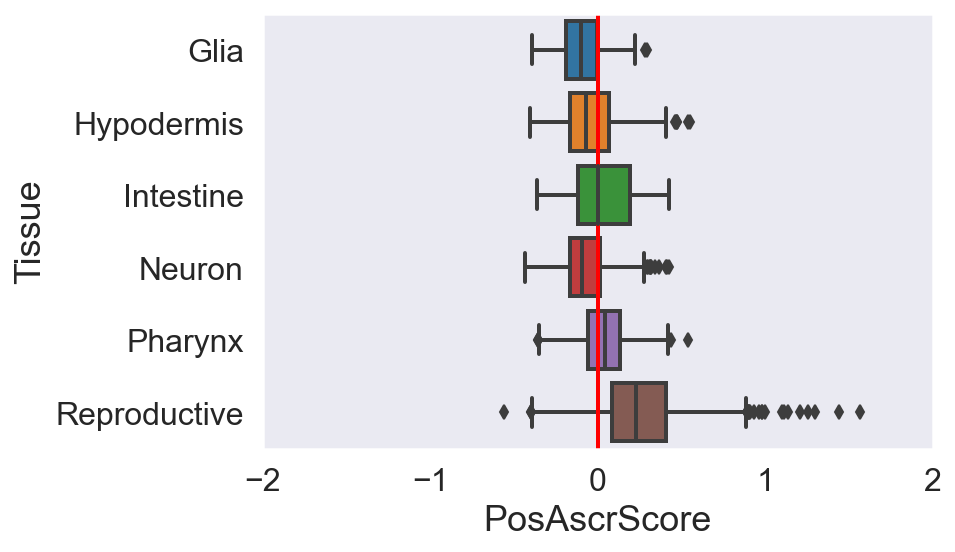

In [63]:
sns.boxplot(y='Tissue', x='PosAscrScore', data=new.obs)
plt.xlim(-2, 2)
plt.axvline(0, color='red')
scores = new.obs.groupby('Tissue').PosAscrScore.apply(np.mean)
scores = scores / scores.max()
scores.sort_values()

Tissue
Pharynx        -0.228372
Neuron         -0.181952
Reproductive    0.053229
Glia            0.059852
Hypodermis      0.522711
Intestine       1.000000
Name: NegAscrScore, dtype: float64

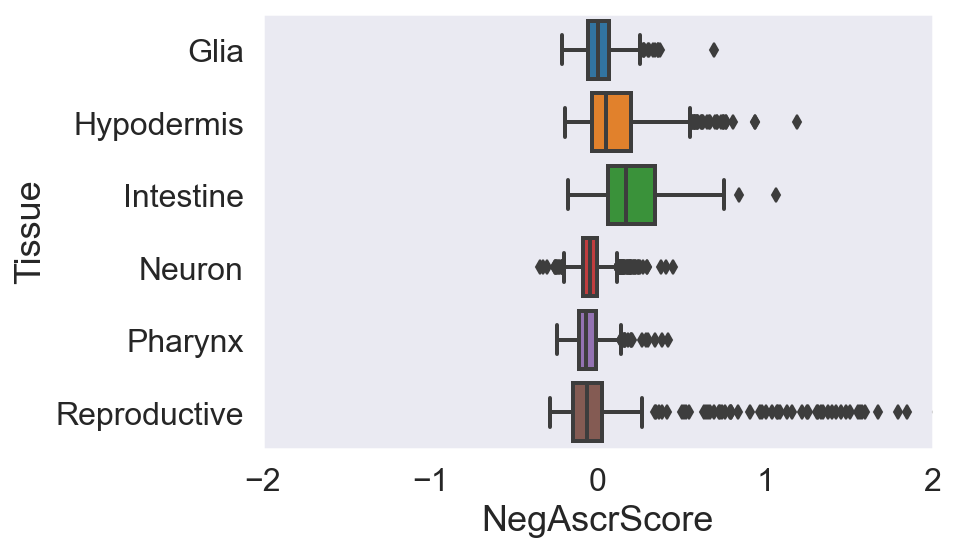

In [64]:
sns.boxplot(y='Tissue', x='NegAscrScore', data=new.obs)
plt.xlim(-2, 2)

neg_scores = new.obs.groupby('Tissue').NegAscrScore.apply(np.mean)
neg_scores = neg_scores / neg_scores.max()
neg_scores.sort_values()

(-2.0, 2.0)

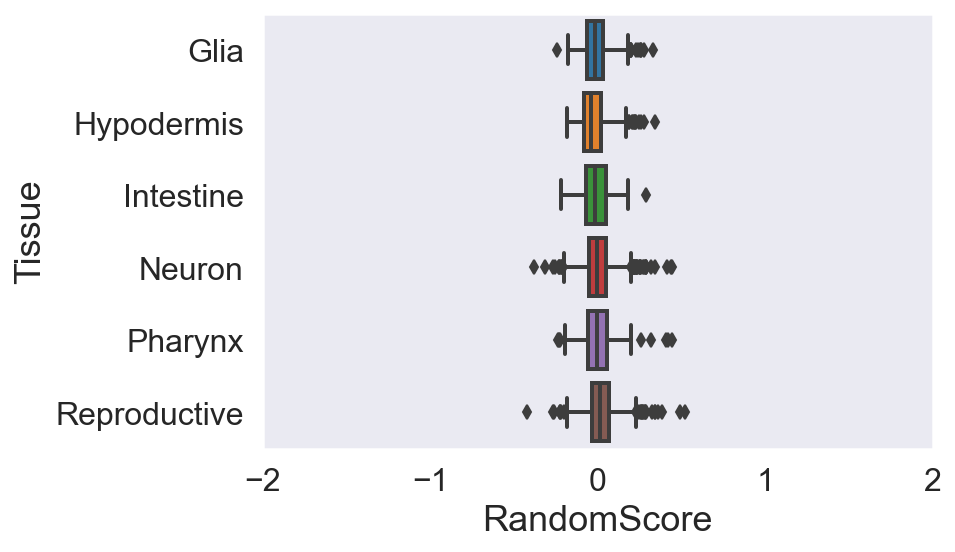

In [65]:
sns.boxplot(y='Tissue', x='RandomScore', data=new.obs)
plt.xlim(-2, 2)


Let's put it all together to generate the colored UMAPs for our paper figures:

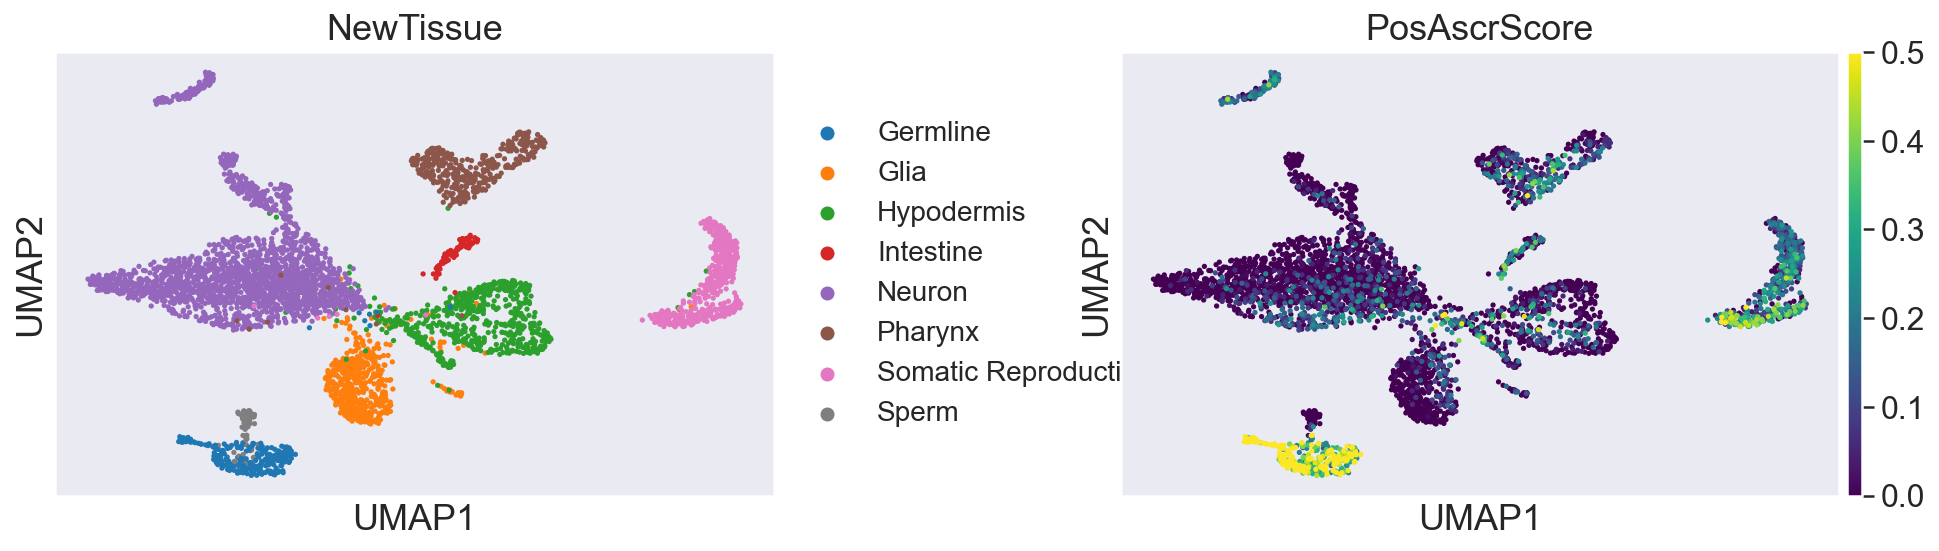

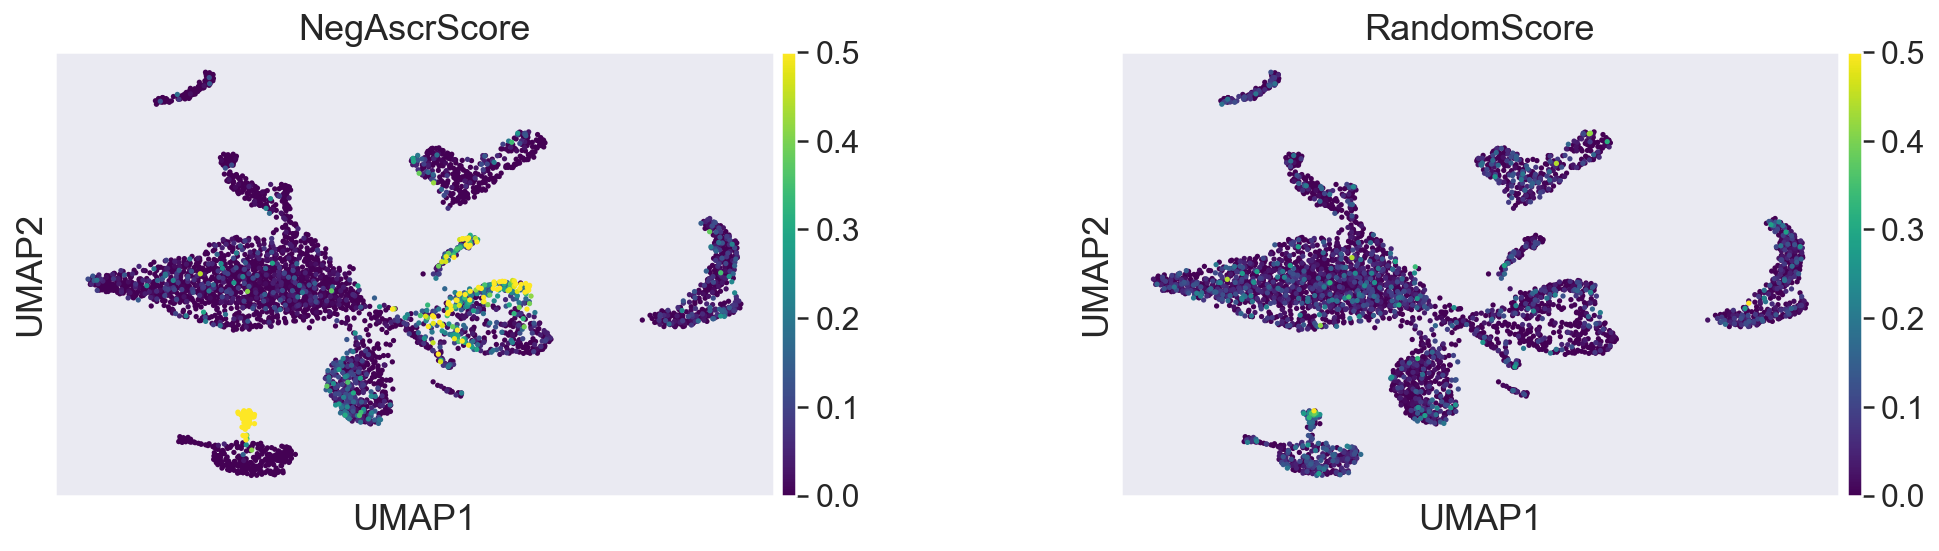

In [66]:
sc.pl.umap(new, color=['NewTissue', 'PosAscrScore'], cmap='viridis', vmax=0.5, vmin=0, wspace=.35, save='_panel_1.svg')
sc.pl.umap(new, color=['NegAscrScore', 'RandomScore'], cmap='viridis', vmax=.5, vmin=0, wspace=.35, save='panel_2.svg')

Finally, just to make absolutely sure our interpretations are correct, let's make a density UMAP plot to reveal where the germline / sperm cells are located in the UMAP plot.

In [67]:
def map_germline(x):
    """A way to drop all labels that are not sperm or germline."""
    if x in ['Sperm', 'Germline']:
        return x
    else:
        return ''

new.obs['Germ'] = new.obs['Cell.type'].apply(map_germline)

... storing 'Germ' as categorical


computing density on 'umap'
--> added
    'umap_density_Germ', densities (adata.obs)
    'umap_density_Germ_params', parameter (adata.uns)


/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:1156: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_over('black')
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:1157: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_under('lightgray')
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/plotting/_tools/scatterplots.py:400: MatplotlibDep

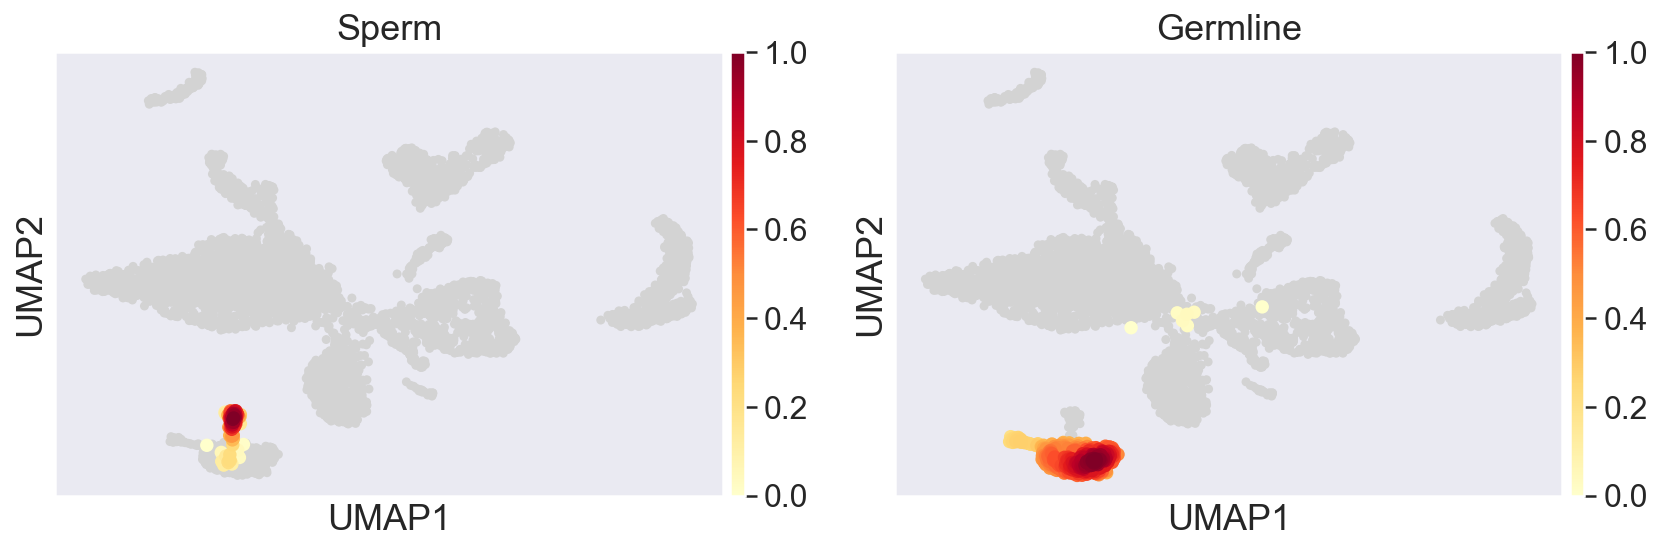

In [68]:
# reality check to look where the sexual cells are going in the UMAP.
sc.tl.embedding_density(new, basis='umap', groupby='Germ')
sc.pl.embedding_density(
    new, basis='umap', key='umap_density_Germ', group=['Sperm', 'Germline']
)


It appears that the sperm and oocyte cells are actually clustered where they appear to be. It's not an artifact! Yay!